# YoloV3: Multi-task Face Detection and Facial Landmark Extraction


## Setup

In [1]:
# Firstly, download pretrained weights and training/test datasets
%cd ..
%pwd
!bash download_weights.sh
%cd ./data/datasets/
!bash download_datasets.sh
%cd ../../src/

# If downloads are failed, please use link below.
# https://drive.google.com/drive/folders/1l2Y_NY0rvmuInvrklbu-wCAHwk62drIY?usp=sharing

/home/sefa/workspace/projects/face_projects/face_detection/after_07092020/yolov3-facial-landmark-detection
^C
ERROR: Operation cancelled by user
/home/sefa/workspace/projects/face_projects/face_detection/after_07092020/yolov3-facial-landmark-detection/data/datasets
/bin/bash: download_datasets.sh: command not found
/home/sefa/workspace/projects/face_projects/face_detection/after_07092020/yolov3-facial-landmark-detection


In [2]:
# Import packages
import cv2
import glob
import random
import torch
import numpy as  np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from pathlib import Path

from models import *
from utils.datasets import *
from utils.utils import *
from hyp import  hyp

from utils.torch_utils import select_device, time_synchronized
from utils.utils import non_max_suppression, xyxy2xywh
from utils.general import scale_coords, plot_one_box, plot_one_landmarks
from utils.inference_datasets import LoadImages, LoadWebcam

In [3]:
def get_model(net_type,  device, weights="", inference=False):
    assert net_type in ["mbv2_1", "mbv2_75", "darknet53"]
    
    if net_type.startswith("mbv2_1"):
        backbone = mobilenet_v2(pretrained=False, width_mult = 1.0)
    elif net_type.startswith("mbv2_75"):
        backbone = mobilenet_v2(pretrained=False, width_mult = 0.75)   
    elif net_type.startswith("darknet53"):
        backbone = DarkNet53()

    if 'light' in net_type:
        net = DarknetWithShh(backbone, hyp, light_head=True).to(device)
    else:
        net = DarknetWithShh(backbone, hyp).to(device)
    
    if weights:
        net.load_state_dict(torch.load(weights, map_location=device)['model'])
        
    if inference:
        net.eval()
        
    return net

## Training

In [4]:
def train(hyp, net_type, device, epochs = 250, batch_size = 16, weights = "" , backbone_weights = "",
          resume = False, img_size = [640]*3, optimizer_str = "adam", multi_scale_training = True,
          rect=False):

    accumulate = max(round(64 / batch_size), 1)  # accumulate n times before optimizer update (bs 64)

    imgsz_min, imgsz_max, imgsz_test = img_size  # img sizes (min, max, test)

    # Image Sizes
    gs = 64  # (pixels) grid size
    assert math.fmod(imgsz_min, gs) == 0, '--img-size %g must be a %g-multiple' % (imgsz_min, gs)
    multi_scale_training |= imgsz_min != imgsz_max  # multi if different (min, max)
    if multi_scale_training:
        if imgsz_min == imgsz_max:
            imgsz_min //= 1.5
            imgsz_max //= 0.667
        grid_min, grid_max = imgsz_min // gs, imgsz_max // gs
        imgsz_min, imgsz_max = int(grid_min * gs), int(grid_max * gs)
    img_size = imgsz_max  # initialize with max size

    # Configure run
    init_seeds()

    # Initialize model
    model = get_model(net_type,  device)
    print(model)
    print(model.info())
    
    # Optimizer
    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for k, v in dict(model.named_parameters()).items():
        if '.bias' in k:
            pg2 += [v]  # biases
        elif 'Conv2d.weight' in k:
            pg1 += [v]  
        else:
            pg0 += [v]  

    if optimizer_str == "adam":
        hyp['lr0'] *= 0.1  # reduce lr (i.e. SGD=5E-3, Adam=5E-4)
        optimizer = optim.Adam(pg0, lr=hyp['lr0'])
    else:
        optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)
        
    optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    print('Optimizer groups: %g .bias, %g Conv2d.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    start_epoch = 0
    best_fitness = 0.0
    
    # Load pretrained weights if exists
    if weights.endswith('.pt'):  
        # Load checkpoints
        chkpt = torch.load(weights, map_location=device)

        # load model
        try:
            chkpt['model'] = {k: v for k, v in chkpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
            model.load_state_dict(chkpt['model'], strict=False)
        except KeyError as e:
            print("Weights could not be loaded!")
            pass
        
        if resume:
            # load optimizer
            if chkpt['optimizer'] is not None:
                optimizer.load_state_dict(chkpt['optimizer'])
                best_fitness = chkpt['best_fitness']

            # load results
            if chkpt.get('training_results') is not None:
                with open(results_file, 'w') as file:
                    file.write(chkpt['training_results'])  # write results.txt

            start_epoch = chkpt['epoch'] + 1
        del chkpt


    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: (((1 + math.cos(x * math.pi / epochs)) / 2) ** 1.0) * 0.95 + 0.05  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    scheduler.last_epoch = start_epoch - 1  

    # Load dataset
    dataset = LoadImagesAndLabels(train_path, img_size, batch_size,
                                  augment=True,
                                  hyp=hyp,  # augmentation hyperparameters
                                  rect=rect,  # rectangular training
                                  cache_images=False,
                                  single_cls=False,
                                  point_number=hyp['point_num'],
                                  flip_idx_pair=hyp['flip_idx_pair']
                                  )

    # Create dataloader
    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             num_workers=nw,
                                             shuffle=not rect,  # Shuffle=True unless rectangular training is used
                                             pin_memory=True,
                                             collate_fn=dataset.collate_fn)


    # Model parameters
    model.hyp = hyp  # attach hyperparameters to model
    model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)


    # Model EMA
    ema = torch_utils.ModelEMA(model)

    # Start training
    nb = len(dataloader)  # number of batches
    n_burn = max(3 * nb, 500)  # burn-in iterations, max(3 epochs, 500 iterations)

    # torch.autograd.set_detect_anomaly(True)
    results = (0, 0, 0, 0, 0, 0, 0)  # 'P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification'
    best_total_loss = np.inf
    t0 = time.time()
    print('Image sizes %g - %g train, %g test' % (imgsz_min, imgsz_max, imgsz_test))
    print('Using %g dataloader workers' % nw)
    print('Starting training for %g epochs...' % epochs)
    
    if weights:
        wdir = "/".join((weights).split("/")[:-1])
    else:
        wdir = "../weights"
    total_losses = []
    for epoch in range(start_epoch, epochs):  
        model.train()

        mloss = torch.zeros(5).to(device)  # mean losses
        print(('\n' + '%10s' * 10) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls','land' , 'total', 'targets', 'img_size','lr'))
        pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
        for i, (imgs, targets, paths, _) in pbar: 
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device).float() / 255.0

            targets = targets.to(device)

            # Burn-in
            if ni <= n_burn:
                xi = [0, n_burn]  # x interp
                model.gr = np.interp(ni, xi, [0.0, 1.0])  # giou loss ratio (obj_loss = 1.0 or giou)
                accumulate = max(1, np.interp(ni, xi, [1, 64 / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    x['weight_decay'] = np.interp(ni, xi, [0.0, hyp['weight_decay'] if j == 1 else 0.0])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [0.9, hyp['momentum']])

            # Multi-Scale
            if multi_scale_training:
                if ni / accumulate % 1 == 0:  #  adjust img_size (67% - 150%) every 1 batch
                    img_size = random.randrange(grid_min, grid_max + 1) * gs
                sf = img_size / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to 32-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            pred = model(imgs)

            # Loss computation
            loss, loss_items = compute_loss(pred, targets, model,point_number=hyp['point_num'])
            if not torch.isfinite(loss):
                print('WARNING: non-finite loss, ending training ', loss_items)
                return results

            loss *= batch_size / 64  # scale loss
            
            # Backpropagation
            loss.backward()

            # Optimizer
            if ni % accumulate == 0:
                optimizer.step()
                optimizer.zero_grad()
                ema.update(model)

            # Print training results
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses  
            mem = '%.3gG' % (torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
    
            s = ('%10s' * 2 + '%10.3g' * 7 + "%10.5g") % ('%g/%g' % (epoch, epochs - 1), mem, *mloss, len(targets), img_size,scheduler.get_lr()[0])
            pbar.set_description(s)
        

        # Update scheduler
        scheduler.step()

        # Process epoch results
        ema.update_attr(model)
        final_epoch = epoch + 1 == epochs
    
        mloss_np = mloss.cpu().numpy()
        total_loss = mloss_np[-1]
        total_losses.append(total_loss)

        chkpt = {'epoch': epoch,
                 'best_fitness': best_fitness,
                 'model': ema.ema.module.state_dict() if hasattr(model, 'module') else ema.ema.state_dict(),
                 'optimizer': None if final_epoch else optimizer.state_dict()}

        # Save last, best and final checkpoints
        torch.save(chkpt, "{}/{}_last.pt".format(wdir, net_type))
        
        if total_loss < best_total_loss:
            torch.save(chkpt, "{}/{}_best.pt".format(wdir, net_type))
        
        
        if  final_epoch:
            torch.save(chkpt, "{}/{}_final.pt".format(wdir, net_type))

        del chkpt
        
    return total_losses

In [5]:
net_type = "mbv2_1"
train_path = "/home/sefa/data/widerface/train/yololandmark_wider_train/"   # Path to training dataset

epochs = 250
batch_size = 16
weights = ""              # initial training weights
backbone_weights = ""
resume = False
img_size = [320, 640, 640]
optimizer_str = "adam"
multi_scale_training = True

In [6]:
device = '0' if torch.cuda.is_available() else 'cpu'         
device = select_device(device)

total_losses = train(hyp, net_type, device, epochs, batch_size, weights , backbone_weights,
                     resume, img_size, optimizer_str, multi_scale_training)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)
           device1 _CudaDeviceProperties(name='Quadro M4000', total_memory=8126MB)

[32, 96, 160]


Caching labels /home/sefa/data/widerface/train/yololandmark_wider_train.npy (788 found, 0 missing, 2 empty, 0 duplicate, for 12880 images):   6%|▌         | 790/12880 [00:00<00:01, 7891.52it/s]

DarknetWithShh(
  (backbone): MobileNetV2(
    (feature_2): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

Caching labels /home/sefa/data/widerface/train/yololandmark_wider_train.npy (12859 found, 0 missing, 21 empty, 0 duplicate, for 12880 images): 100%|██████████| 12880/12880 [00:01<00:00, 7787.11it/s]


Image sizes 320 - 640 train, 640 test
Using 8 dataloader workers
Starting training for 250 epochs...

     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


  0%|          | 0/805 [00:00<?, ?it/s]/home/sefa/miniconda3/envs/py37/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/home/sefa/miniconda3/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
     0/249      9.6G      5.61        14         0      6.61      26.2        91       5120.00099996: 100%|██████████| 805/805 [03:59<00:00,  3.37it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     1/249      9.6G       5.1      6.42         0      4.91      16.4        73       512     0.001: 100%|██████████| 805/805 [03:35<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     2/249      9.6G      4.72      4.89         0      4.69      14.3        42       4480.00099996: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     3/249      9.6G      4.42         4         0       4.5      12.9        60       3200.00099985: 100%|██████████| 805/805 [03:45<00:00,  3.58it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     4/249      9.6G      4.18      3.62         0      4.21        12        44       6400.00099966: 100%|██████████| 805/805 [03:46<00:00,  3.55it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     5/249      9.6G      3.95      3.47         0      3.91      11.3        79       448 0.0009994: 100%|██████████| 805/805 [03:40<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     6/249      9.6G      3.77      3.37         0      3.55      10.7       115       4480.00099906: 100%|██████████| 805/805 [03:23<00:00,  3.95it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     7/249      9.6G       3.6      3.11         0      3.51      10.2        51       3200.00099865: 100%|██████████| 805/805 [03:43<00:00,  3.61it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     8/249      9.6G      3.47       3.1         0      3.27      9.84        51       3200.00099816: 100%|██████████| 805/805 [03:27<00:00,  3.89it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


     9/249      9.6G      3.39      2.91         0      3.22      9.52       104       640 0.0009976: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    10/249      9.6G      3.31       2.9         0      3.05      9.26        74       3840.00099697: 100%|██████████| 805/805 [03:26<00:00,  3.90it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    11/249      9.6G      3.24      2.79         0      3.02      9.05       126       3840.00099625: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    12/249      9.6G      3.19      2.78         0      2.95      8.92       158       3840.00099547: 100%|██████████| 805/805 [03:33<00:00,  3.77it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    13/249      9.6G      3.14      2.63         0      2.93      8.69        36       5760.00099461: 100%|██████████| 805/805 [03:41<00:00,  3.63it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    14/249      9.6G      3.08      2.65         0      2.81      8.54        42       6400.00099368: 100%|██████████| 805/805 [03:38<00:00,  3.69it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    15/249      9.6G      3.08      2.65         0      2.82      8.55        32       4480.00099267: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    16/249      9.6G      3.03      2.61         0      2.67      8.31        58       5760.00099159: 100%|██████████| 805/805 [03:31<00:00,  3.80it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    17/249      9.6G      2.98      2.55         0      2.66       8.2       163       3200.00099043: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    18/249      9.6G         3      2.59         0      2.64      8.23       117       640 0.0009892: 100%|██████████| 805/805 [03:34<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    19/249      9.6G      2.97       2.5         0      2.65      8.12       153       320 0.0009879: 100%|██████████| 805/805 [03:40<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    20/249      9.6G      2.94      2.55         0      2.53      8.02       194       3840.00098653: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    21/249      9.6G      2.91       2.5         0      2.48       7.9       450       3200.00098508: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    22/249      9.6G      2.88      2.53         0      2.49       7.9       193       3840.00098356: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    23/249      9.6G      2.88      2.47         0      2.44      7.79       108       5760.00098196: 100%|██████████| 805/805 [03:28<00:00,  3.87it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    24/249      9.6G      2.87      2.45         0      2.49      7.82        73       448 0.0009803: 100%|██████████| 805/805 [03:39<00:00,  3.67it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    25/249      9.6G      2.85      2.43         0      2.44      7.72       192       3840.00097856: 100%|██████████| 805/805 [03:34<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    26/249      9.6G      2.84      2.47         0      2.39       7.7       124       6400.00097675: 100%|██████████| 805/805 [03:23<00:00,  3.96it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    27/249      9.6G      2.82      2.44         0      2.39      7.66        76       3200.00097487: 100%|██████████| 805/805 [03:29<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    28/249      9.6G      2.82      2.43         0      2.36       7.6       132       4480.00097292: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    29/249      9.6G       2.8      2.41         0      2.37      7.58        93       640 0.0009709: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    30/249      9.6G      2.76      2.34         0      2.34      7.45        46       6400.00096881: 100%|██████████| 805/805 [03:36<00:00,  3.72it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    31/249      9.6G      2.77      2.41         0      2.28      7.45       156       4480.00096664: 100%|██████████| 805/805 [03:29<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    32/249      9.6G      2.75      2.35         0      2.31      7.41        45       5120.00096441: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    33/249      9.6G      2.74      2.32         0      2.31      7.37       102       6400.00096211: 100%|██████████| 805/805 [03:39<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    34/249      9.6G      2.73      2.31         0      2.27      7.31       222       3840.00095974: 100%|██████████| 805/805 [03:39<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    35/249      9.6G      2.74      2.35         0      2.25      7.34        66       320 0.0009573: 100%|██████████| 805/805 [03:30<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    36/249      9.6G       2.7      2.36         0       2.2      7.26        46       3200.00095479: 100%|██████████| 805/805 [03:27<00:00,  3.89it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    37/249      9.6G      2.69      2.31         0      2.21       7.2        79       4480.00095222: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    38/249      9.6G      2.69      2.31         0      2.17      7.17        54       3840.00094957: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    39/249      9.6G       2.7      2.33         0      2.13      7.17       133       6400.00094686: 100%|██████████| 805/805 [03:27<00:00,  3.88it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    40/249      9.6G      2.67      2.29         0      2.18      7.14        76       3840.00094409: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    41/249      9.6G      2.66      2.27         0      2.19      7.12       234       6400.00094125: 100%|██████████| 805/805 [03:34<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    42/249      9.6G      2.66      2.29         0      2.11      7.06        80       5760.00093834: 100%|██████████| 805/805 [03:28<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    43/249      9.6G      2.64      2.26         0      2.17      7.07        52       3200.00093536: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    44/249      9.6G      2.64      2.28         0       2.1      7.03        42       3200.00093233: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    45/249      9.6G      2.62      2.26         0      2.09      6.97        60       3200.00092922: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    46/249      9.6G      2.61       2.2         0      2.15      6.96        55       3840.00092606: 100%|██████████| 805/805 [03:39<00:00,  3.67it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    47/249      9.6G      2.62      2.21         0       2.1      6.93        56       4480.00092283: 100%|██████████| 805/805 [03:37<00:00,  3.71it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    48/249      9.6G      2.62      2.24         0      2.08      6.93        32       5120.00091953: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    49/249      9.6G      2.61      2.21         0      2.11      6.93        74       6400.00091618: 100%|██████████| 805/805 [03:41<00:00,  3.63it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    50/249      9.6G       2.6      2.24         0      2.05      6.89        69       3200.00091276: 100%|██████████| 805/805 [03:25<00:00,  3.93it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    51/249      9.6G      2.59      2.19         0      2.05      6.84        53       5120.00090928: 100%|██████████| 805/805 [03:35<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    52/249      9.6G      2.59      2.24         0      2.04      6.86        49       5120.00090574: 100%|██████████| 805/805 [03:33<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    53/249      9.6G      2.57      2.27         0      2.04      6.88        45       5120.00090215: 100%|██████████| 805/805 [03:22<00:00,  3.97it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    54/249      9.6G      2.57       2.2         0      2.01      6.77       163       3200.00089849: 100%|██████████| 805/805 [03:28<00:00,  3.87it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    55/249      9.6G      2.56      2.19         0      1.99      6.74       137       5120.00089477: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    56/249      9.6G      2.56      2.15         0      2.02      6.73        69       5120.00089099: 100%|██████████| 805/805 [03:38<00:00,  3.68it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    57/249      9.6G      2.56      2.21         0         2      6.76        70       5760.00088716: 100%|██████████| 805/805 [03:32<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    58/249      9.6G      2.54      2.21         0      1.95       6.7       108       4480.00088327: 100%|██████████| 805/805 [03:25<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    59/249      9.6G      2.56      2.18         0      1.97       6.7        96       3840.00087932: 100%|██████████| 805/805 [03:31<00:00,  3.80it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    60/249      9.6G      2.54      2.15         0      2.02      6.72        63       5120.00087532: 100%|██████████| 805/805 [03:42<00:00,  3.63it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    61/249      9.6G      2.53      2.15         0      1.95      6.64        61       6400.00087126: 100%|██████████| 805/805 [03:30<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    62/249      9.6G      2.53      2.17         0      1.98      6.68        50       5120.00086715: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    63/249      9.6G      2.51      2.15         0      1.97      6.63        84       3200.00086298: 100%|██████████| 805/805 [03:33<00:00,  3.77it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    64/249      9.6G      2.52      2.16         0      1.92       6.6        37       4480.00085876: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    65/249      9.6G       2.5      2.13         0      1.95      6.59        63       3200.00085449: 100%|██████████| 805/805 [03:35<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    66/249      9.6G      2.51      2.16         0      1.95      6.62        58       6400.00085016: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    67/249      9.6G       2.5      2.16         0      1.93      6.59        45       5760.00084578: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    68/249      9.6G       2.5      2.13         0      1.94      6.58        95       5760.00084136: 100%|██████████| 805/805 [03:36<00:00,  3.71it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    69/249      9.6G      2.49      2.12         0       1.9      6.52       123       4480.00083688: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    70/249      9.6G      2.49      2.18         0      1.87      6.54       119       4480.00083235: 100%|██████████| 805/805 [03:24<00:00,  3.94it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    71/249      9.6G      2.47      2.12         0      1.91       6.5        77       3840.00082778: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    72/249      9.6G      2.47       2.1         0       1.9      6.47       130       5120.00082315: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    73/249      9.6G      2.46      2.08         0       1.9      6.44        61       4480.00081848: 100%|██████████| 805/805 [03:38<00:00,  3.69it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    74/249      9.6G      2.46      2.04         0      1.92      6.41        61       4480.00081377: 100%|██████████| 805/805 [03:44<00:00,  3.58it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    75/249      9.6G      2.47      2.08         0      1.87      6.42        55       384  0.000809: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    76/249      9.6G      2.45       2.1         0       1.9      6.45        78       448 0.0008042: 100%|██████████| 805/805 [03:37<00:00,  3.71it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    77/249      9.6G      2.45      2.13         0      1.88      6.46       135       4480.00079935: 100%|██████████| 805/805 [03:34<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    78/249      9.6G      2.45       2.1         0      1.87      6.43        80       3840.00079445: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    79/249      9.6G      2.45      2.04         0      1.87      6.36        94       6400.00078952: 100%|██████████| 805/805 [03:39<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    80/249      9.6G      2.45      2.11         0      1.84       6.4        86       5120.00078454: 100%|██████████| 805/805 [03:23<00:00,  3.95it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    81/249      9.6G      2.44      2.05         0      1.86      6.35        48       5120.00077952: 100%|██████████| 805/805 [03:40<00:00,  3.65it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    82/249      9.6G      2.44      2.15         0      1.84      6.43        70       5760.00077446: 100%|██████████| 805/805 [03:22<00:00,  3.97it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    83/249      9.6G      2.43      2.12         0      1.81      6.35        88       5760.00076936: 100%|██████████| 805/805 [03:24<00:00,  3.94it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    84/249      9.6G      2.44      2.11         0      1.84      6.38        82       6400.00076422: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    85/249      9.6G      2.42      2.07         0      1.82      6.31        42       6400.00075905: 100%|██████████| 805/805 [03:33<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    86/249      9.6G      2.42      2.04         0      1.86      6.31        38       5760.00075383: 100%|██████████| 805/805 [03:39<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    87/249      9.6G      2.41      2.03         0      1.84      6.28       109       3200.00074858: 100%|██████████| 805/805 [03:39<00:00,  3.67it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    88/249      9.6G      2.41       2.1         0      1.82      6.33        71       448 0.0007433: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    89/249      9.6G       2.4      2.07         0      1.82      6.29       158       3200.00073798: 100%|██████████| 805/805 [03:29<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    90/249      9.6G      2.41      2.09         0      1.77      6.27        47       4480.00073263: 100%|██████████| 805/805 [03:25<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    91/249      9.6G       2.4      2.09         0      1.75      6.25       158       6400.00072725: 100%|██████████| 805/805 [03:24<00:00,  3.94it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    92/249      9.6G      2.39      2.09         0      1.78      6.26       156       5120.00072183: 100%|██████████| 805/805 [03:27<00:00,  3.88it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    93/249      9.6G      2.38      2.07         0       1.8      6.25        76       6400.00071638: 100%|██████████| 805/805 [03:27<00:00,  3.87it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    94/249      9.6G      2.39         2         0      1.81       6.2        57       320 0.0007109: 100%|██████████| 805/805 [03:38<00:00,  3.68it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    95/249      9.6G      2.39      2.05         0      1.79      6.23       263       512 0.0007054: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    96/249      9.6G       2.4      2.05         0       1.8      6.26       115       6400.00069986: 100%|██████████| 805/805 [03:34<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    97/249      9.6G      2.38      2.09         0      1.76      6.24        72       640 0.0006943: 100%|██████████| 805/805 [03:26<00:00,  3.89it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    98/249      9.6G      2.39      2.03         0      1.83      6.25        41       4480.00068871: 100%|██████████| 805/805 [03:39<00:00,  3.68it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


    99/249      9.6G      2.38      2.02         0      1.77      6.17        94       3840.00068309: 100%|██████████| 805/805 [03:35<00:00,  3.73it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   100/249      9.6G      2.38         2         0       1.8      6.18        57       5120.00067745: 100%|██████████| 805/805 [03:39<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   101/249      9.6G      2.37      2.09         0      1.76      6.23        97       6400.00067178: 100%|██████████| 805/805 [03:26<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   102/249      9.6G      2.37      2.06         0      1.74      6.16       299       4480.00066609: 100%|██████████| 805/805 [03:28<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   103/249      9.6G      2.36      2.07         0      1.73      6.17       121       6400.00066038: 100%|██████████| 805/805 [03:29<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   104/249      9.6G      2.37      2.03         0      1.73      6.12        76       3200.00065465: 100%|██████████| 805/805 [03:32<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   105/249      9.6G      2.36      2.01         0      1.77      6.14        79       512 0.0006489: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   106/249      9.6G      2.35      2.07         0      1.75      6.17       100       3200.00064313: 100%|██████████| 805/805 [03:25<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   107/249      9.6G      2.35      2.03         0      1.74      6.11        71       4480.00063734: 100%|██████████| 805/805 [03:30<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   108/249      9.6G      2.34      1.99         0      1.73      6.06        95       4480.00063153: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   109/249      9.6G      2.36      2.03         0      1.74      6.12        60       576 0.0006257: 100%|██████████| 805/805 [03:32<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   110/249      9.6G      2.34      2.04         0      1.72      6.09        89       5120.00061986: 100%|██████████| 805/805 [03:27<00:00,  3.87it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   111/249      9.6G      2.35      2.05         0       1.7       6.1       135       5760.00061401: 100%|██████████| 805/805 [03:27<00:00,  3.89it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   112/249      9.6G      2.35      2.02         0      1.74      6.12        97       5760.00060814: 100%|██████████| 805/805 [03:31<00:00,  3.80it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   113/249      9.6G      2.33         2         0      1.73      6.06       130       3200.00060225: 100%|██████████| 805/805 [03:36<00:00,  3.71it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   114/249      9.6G      2.34      2.01         0      1.72      6.07        68       6400.00059636: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   115/249      9.6G      2.34      1.97         0      1.74      6.04       113       5120.00059045: 100%|██████████| 805/805 [03:44<00:00,  3.58it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   116/249      9.6G      2.33      2.01         0      1.72      6.07        43       4480.00058453: 100%|██████████| 805/805 [03:36<00:00,  3.73it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   117/249      9.6G      2.33      1.98         0      1.72      6.03        60       3840.00057861: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   118/249      9.6G      2.31         2         0      1.69      6.01       145       6400.00057267: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   119/249      9.6G      2.31      2.04         0       1.7      6.05       139       5760.00056673: 100%|██████████| 805/805 [03:28<00:00,  3.87it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   120/249      9.6G      2.32      2.01         0      1.69      6.02        90       3200.00056078: 100%|██████████| 805/805 [03:32<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   121/249      9.6G       2.3      1.94         0      1.71      5.95        33       5120.00055483: 100%|██████████| 805/805 [03:39<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   122/249      9.6G      2.32      1.98         0      1.69         6        42       3840.00054887: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   123/249      9.6G       2.3      1.96         0      1.69      5.96        52       576 0.0005429: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   124/249      9.6G      2.31      1.96         0      1.68      5.95        68       3200.00053694: 100%|██████████| 805/805 [03:33<00:00,  3.77it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   125/249      9.6G       2.3      2.03         0      1.65      5.99        60       3840.00053097: 100%|██████████| 805/805 [03:25<00:00,  3.92it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   126/249      9.6G       2.3      1.96         0       1.7      5.96        69       448  0.000525: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   127/249      9.6G       2.3      2.01         0      1.66      5.97       297       4480.00051903: 100%|██████████| 805/805 [03:26<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   128/249      9.6G      2.31      1.98         0      1.69      5.98       109       5760.00051306: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   129/249      9.6G      2.29         2         0      1.66      5.94       164       576 0.0005071: 100%|██████████| 805/805 [03:33<00:00,  3.77it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   130/249      9.6G      2.28      1.89         0      1.73      5.91        56       5760.00050113: 100%|██████████| 805/805 [03:44<00:00,  3.59it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   131/249      9.6G      2.29      1.95         0      1.66      5.91        43       4480.00049517: 100%|██████████| 805/805 [03:33<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   132/249      9.6G      2.29      1.98         0      1.67      5.94       106       6400.00048922: 100%|██████████| 805/805 [03:30<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   133/249      9.6G      2.27      1.97         0       1.7      5.94       179       5760.00048327: 100%|██████████| 805/805 [03:36<00:00,  3.72it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   134/249      9.6G      2.28      1.94         0      1.67      5.89       124       3840.00047733: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   135/249      9.6G      2.29      1.94         0      1.64      5.87        63       4480.00047139: 100%|██████████| 805/805 [03:36<00:00,  3.72it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   136/249      9.6G      2.28      1.93         0      1.72      5.92        66       3840.00046547: 100%|██████████| 805/805 [03:42<00:00,  3.62it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   137/249      9.6G      2.29       1.9         0      1.69      5.88        61       4480.00045955: 100%|██████████| 805/805 [03:44<00:00,  3.58it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   138/249      9.6G      2.28      1.94         0      1.67      5.89        82       4480.00045364: 100%|██████████| 805/805 [03:38<00:00,  3.69it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   139/249      9.6G      2.26      1.93         0      1.64      5.83       289       4480.00044775: 100%|██████████| 805/805 [03:36<00:00,  3.72it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   140/249      9.6G      2.27         2         0      1.64      5.91        65       5120.00044186: 100%|██████████| 805/805 [03:26<00:00,  3.89it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   141/249      9.6G      2.26       1.9         0      1.66      5.83        65       3200.00043599: 100%|██████████| 805/805 [03:43<00:00,  3.61it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   142/249      9.6G      2.26       1.9         0      1.64      5.81        70       6400.00043014: 100%|██████████| 805/805 [03:42<00:00,  3.62it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   143/249      9.6G      2.25      1.99         0      1.58      5.83        80       640 0.0004243: 100%|██████████| 805/805 [03:22<00:00,  3.97it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   144/249      9.6G      2.25      1.97         0      1.64      5.86        49       3840.00041847: 100%|██████████| 805/805 [03:27<00:00,  3.88it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   145/249      9.6G      2.26      1.95         0      1.65      5.85        61       3200.00041266: 100%|██████████| 805/805 [03:37<00:00,  3.69it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   146/249      9.6G      2.26      1.96         0      1.63      5.85        46       3200.00040687: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   147/249      9.6G      2.25      1.96         0      1.64      5.85        69       448 0.0004011: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   148/249      9.6G      2.24      1.97         0      1.62      5.83        82       5120.00039535: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   149/249      9.6G      2.26      1.97         0      1.62      5.85        54       4480.00038962: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   150/249      9.6G      2.25      1.94         0      1.62      5.82        63       4480.00038391: 100%|██████████| 805/805 [03:34<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   151/249      9.6G      2.24      1.96         0      1.61       5.8        58       5760.00037822: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   152/249      9.6G      2.22      1.98         0      1.56      5.77       101       6400.00037255: 100%|██████████| 805/805 [03:25<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   153/249      9.6G      2.24      1.93         0      1.58      5.75       107       3200.00036691: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   154/249      9.6G      2.23      1.93         0      1.62      5.78       214       6400.00036129: 100%|██████████| 805/805 [03:40<00:00,  3.65it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   155/249      9.6G      2.24      1.94         0      1.59      5.76       146       640 0.0003557: 100%|██████████| 805/805 [03:30<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   156/249      9.6G      2.23      1.98         0      1.59      5.81       158       6400.00035014: 100%|██████████| 805/805 [03:26<00:00,  3.90it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   157/249      9.6G      2.24      1.95         0      1.62       5.8       157       640 0.0003446: 100%|██████████| 805/805 [03:33<00:00,  3.77it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   158/249      9.6G      2.22         2         0      1.57       5.8       312       512 0.0003391: 100%|██████████| 805/805 [03:25<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   159/249      9.6G      2.23      1.92         0      1.61      5.76        65       3840.00033362: 100%|██████████| 805/805 [03:35<00:00,  3.73it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   160/249      9.6G      2.23      1.94         0      1.58      5.76        35       3200.00032817: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   161/249      9.6G      2.23      1.91         0      1.62      5.77        57       4480.00032275: 100%|██████████| 805/805 [03:36<00:00,  3.71it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   162/249      9.6G      2.24      1.88         0      1.62      5.73        39       3840.00031737: 100%|██████████| 805/805 [03:44<00:00,  3.58it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   163/249      9.6G      2.22      1.97         0      1.57      5.76       124       5760.00031202: 100%|██████████| 805/805 [03:23<00:00,  3.95it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   164/249      9.6G      2.23      1.97         0      1.57      5.76        41       384 0.0003067: 100%|██████████| 805/805 [03:24<00:00,  3.94it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   165/249      9.6G      2.23      1.98         0      1.59       5.8        45       3840.00030142: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   166/249      9.6G      2.21      1.92         0      1.58      5.71        82       6400.00029617: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   167/249      9.6G      2.23      1.91         0      1.59      5.74        59       5760.00029095: 100%|██████████| 805/805 [03:31<00:00,  3.81it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   168/249      9.6G      2.23      1.91         0      1.57      5.72        43       5120.00028578: 100%|██████████| 805/805 [03:35<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   169/249      9.6G      2.21      1.93         0       1.6      5.73       204       3200.00028064: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   170/249      9.6G      2.22      1.92         0      1.58      5.71        77       3200.00027554: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   171/249      9.6G      2.21      1.94         0      1.56      5.72        52       4480.00027048: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   172/249      9.6G      2.22      1.91         0      1.59      5.72        80       5120.00026546: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   173/249      9.6G      2.21      1.91         0      1.56      5.69        48       3200.00026048: 100%|██████████| 805/805 [03:33<00:00,  3.77it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   174/249      9.6G       2.2       1.9         0      1.58      5.68        98       5120.00025555: 100%|██████████| 805/805 [03:32<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   175/249      9.6G       2.2      1.95         0      1.57      5.72        47       3840.00025065: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   176/249      9.6G      2.21      1.97         0      1.54      5.71        97       640 0.0002458: 100%|██████████| 805/805 [03:20<00:00,  4.01it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   177/249      9.6G      2.19       1.9         0      1.56      5.65       110       384  0.000241: 100%|██████████| 805/805 [03:37<00:00,  3.71it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   178/249      9.6G      2.21      1.97         0      1.54      5.72        94       3840.00023623: 100%|██████████| 805/805 [03:21<00:00,  4.00it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   179/249      9.6G       2.2      1.89         0       1.6      5.69       184       5760.00023152: 100%|██████████| 805/805 [03:36<00:00,  3.72it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   180/249      9.6G      2.19      1.91         0      1.58      5.67        77       3200.00022685: 100%|██████████| 805/805 [03:34<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   181/249      9.6G      2.19      1.82         0       1.6      5.61        75       5120.00022222: 100%|██████████| 805/805 [03:45<00:00,  3.56it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   182/249      9.6G      2.19      1.91         0      1.52      5.63        46       4480.00021765: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   183/249      9.6G      2.19      1.89         0      1.56      5.64        37       3200.00021312: 100%|██████████| 805/805 [03:35<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   184/249      9.6G       2.2      1.88         0      1.55      5.63       103       6400.00020864: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   185/249      9.6G      2.18      1.85         0      1.58      5.61        54       5120.00020422: 100%|██████████| 805/805 [03:40<00:00,  3.65it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   186/249      9.6G      2.19      1.94         0      1.55      5.68       127       3840.00019984: 100%|██████████| 805/805 [03:31<00:00,  3.80it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   187/249      9.6G      2.19      1.93         0      1.53      5.65       101       5120.00019551: 100%|██████████| 805/805 [03:27<00:00,  3.88it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   188/249      9.6G      2.18       1.9         0      1.56      5.64        75       4480.00019124: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   189/249      9.6G      2.18      1.92         0      1.51      5.61        90       4480.00018702: 100%|██████████| 805/805 [03:21<00:00,  4.00it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   190/249      9.6G      2.18      1.84         0      1.56      5.58        34       4480.00018285: 100%|██████████| 805/805 [03:40<00:00,  3.64it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   191/249      9.6G      2.19      1.88         0      1.56      5.63        81       3840.00017874: 100%|██████████| 805/805 [03:36<00:00,  3.72it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   192/249      9.6G      2.18      1.85         0      1.56      5.59       133       3840.00017468: 100%|██████████| 805/805 [03:41<00:00,  3.63it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   193/249      9.6G      2.18      1.94         0       1.5      5.63        36       5760.00017068: 100%|██████████| 805/805 [03:20<00:00,  4.01it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   194/249      9.6G       2.2      1.88         0      1.55      5.63        60       3840.00016673: 100%|██████████| 805/805 [03:33<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   195/249      9.6G      2.18      1.93         0      1.54      5.64       136       3200.00016284: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   196/249      9.6G      2.16       1.9         0      1.56      5.62        80       6400.00015901: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   197/249      9.6G      2.17      1.84         0      1.56      5.57        58       3840.00015523: 100%|██████████| 805/805 [03:42<00:00,  3.62it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   198/249      9.6G      2.17      1.85         0      1.55      5.57        79       5120.00015151: 100%|██████████| 805/805 [03:38<00:00,  3.68it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   199/249      9.6G      2.17      1.93         0      1.52      5.62       120       6400.00014785: 100%|██████████| 805/805 [03:26<00:00,  3.90it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   200/249      9.6G      2.18       1.9         0      1.53       5.6       117       3200.00014426: 100%|██████████| 805/805 [03:28<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   201/249      9.6G      2.17      1.84         0      1.54      5.55        39       5120.00014072: 100%|██████████| 805/805 [03:43<00:00,  3.60it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   202/249      9.6G      2.17      1.84         0      1.56      5.58        48       6400.00013724: 100%|██████████| 805/805 [03:46<00:00,  3.56it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   203/249      9.6G      2.17      1.89         0      1.52      5.58        91       5760.00013382: 100%|██████████| 805/805 [03:34<00:00,  3.75it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   204/249      9.6G      2.17      1.85         0      1.55      5.57        41       5120.00013047: 100%|██████████| 805/805 [03:40<00:00,  3.65it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   205/249      9.6G      2.17      1.83         0      1.53      5.52       142       6400.00012717: 100%|██████████| 805/805 [03:39<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   206/249      9.6G      2.18      1.83         0      1.54      5.55        70       6400.00012394: 100%|██████████| 805/805 [03:40<00:00,  3.65it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   207/249      9.6G      2.16      1.85         0      1.53      5.54       195       4480.00012078: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   208/249      9.6G      2.16      1.86         0      1.54      5.56        65       5120.00011767: 100%|██████████| 805/805 [03:40<00:00,  3.66it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   209/249      9.6G      2.16      1.85         0      1.53      5.53       161       3840.00011464: 100%|██████████| 805/805 [03:39<00:00,  3.67it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   210/249      9.6G      2.16      1.88         0      1.53      5.58        98       4480.00011166: 100%|██████████| 805/805 [03:35<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   211/249      9.6G      2.16      1.87         0      1.51      5.54        49       4480.00010875: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   212/249      9.6G      2.16      1.92         0      1.51      5.59        39       3200.00010591: 100%|██████████| 805/805 [03:25<00:00,  3.91it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   213/249      9.6G      2.16      1.85         0      1.55      5.56       113       4480.00010314: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   214/249      9.6G      2.17      1.87         0       1.5      5.53        87       5760.00010043: 100%|██████████| 805/805 [03:32<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   215/249      9.6G      2.16      1.91         0      1.53       5.6        95       5769.7783e-05: 100%|██████████| 805/805 [03:29<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   216/249      9.6G      2.16      1.86         0       1.5      5.52        73       6409.5207e-05: 100%|██████████| 805/805 [03:33<00:00,  3.77it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   217/249      9.6G      2.16      1.84         0      1.52      5.52        85       448  9.27e-05: 100%|██████████| 805/805 [03:38<00:00,  3.69it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   218/249      9.6G      2.16       1.8         0      1.54      5.51        79       384 9.026e-05: 100%|██████████| 805/805 [03:47<00:00,  3.54it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   219/249      9.6G      2.16      1.84         0      1.51      5.51        23       384 8.789e-05: 100%|██████████| 805/805 [03:36<00:00,  3.72it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   220/249      9.6G      2.15      1.89         0       1.5      5.55        52       3848.5588e-05: 100%|██████████| 805/805 [03:27<00:00,  3.88it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   221/249      9.6G      2.15      1.89         0      1.49      5.54        35       5768.3356e-05: 100%|██████████| 805/805 [03:29<00:00,  3.85it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   222/249      9.6G      2.16      1.83         0      1.54      5.52        68       3208.1194e-05: 100%|██████████| 805/805 [03:38<00:00,  3.69it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   223/249      9.6G      2.15      1.88         0       1.5      5.52        72       4487.9101e-05: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   224/249      9.6G      2.15       1.9         0      1.48      5.53        52       6407.7079e-05: 100%|██████████| 805/805 [03:21<00:00,  3.99it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   225/249      9.6G      2.15       1.9         0      1.48      5.53        45       6407.5128e-05: 100%|██████████| 805/805 [03:24<00:00,  3.93it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   226/249      9.6G      2.16      1.91         0       1.5      5.57        93       3207.3248e-05: 100%|██████████| 805/805 [03:28<00:00,  3.86it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   227/249      9.6G      2.16      1.87         0      1.52      5.55        65       3847.1439e-05: 100%|██████████| 805/805 [03:34<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   228/249      9.6G      2.16      1.89         0      1.49      5.55        49       5766.9702e-05: 100%|██████████| 805/805 [03:27<00:00,  3.88it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   229/249      9.6G      2.14      1.87         0      1.52      5.54        43       3206.8037e-05: 100%|██████████| 805/805 [03:37<00:00,  3.70it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   230/249      9.6G      2.15      1.83         0      1.54      5.51        76       5766.6444e-05: 100%|██████████| 805/805 [03:40<00:00,  3.64it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   231/249      9.6G      2.14      1.89         0      1.46      5.49        40       5766.4923e-05: 100%|██████████| 805/805 [03:25<00:00,  3.92it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   232/249      9.6G      2.15      1.87         0      1.49      5.51        83       4486.3475e-05: 100%|██████████| 805/805 [03:33<00:00,  3.78it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   233/249      9.6G      2.14      1.87         0       1.5      5.52        84       448  6.21e-05: 100%|██████████| 805/805 [03:34<00:00,  3.76it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   234/249      9.6G      2.14      1.88         0      1.49      5.52       139       6406.0798e-05: 100%|██████████| 805/805 [03:32<00:00,  3.79it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   235/249      9.6G      2.15      1.89         0      1.49      5.52        99       5125.9569e-05: 100%|██████████| 805/805 [03:31<00:00,  3.80it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   236/249      9.6G      2.14      1.89         0      1.51      5.54       259       3845.8414e-05: 100%|██████████| 805/805 [03:31<00:00,  3.80it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   237/249      9.6G      2.13      1.87         0      1.54      5.54        48       5125.7332e-05: 100%|██████████| 805/805 [03:37<00:00,  3.71it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   238/249      9.6G      2.14      1.83         0      1.56      5.53        89       3845.6324e-05: 100%|██████████| 805/805 [03:43<00:00,  3.61it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   239/249      9.6G      2.15      1.85         0      1.52      5.51       191       512 5.539e-05: 100%|██████████| 805/805 [03:38<00:00,  3.69it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   240/249      9.6G      2.15      1.86         0      1.52      5.53        40       5125.4531e-05: 100%|██████████| 805/805 [03:35<00:00,  3.74it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   241/249      9.6G      2.14      1.82         0      1.54       5.5       186       3205.3746e-05: 100%|██████████| 805/805 [03:38<00:00,  3.68it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   242/249      9.6G      2.14      1.87         0       1.5      5.52       291       3845.3035e-05: 100%|██████████| 805/805 [03:29<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   243/249      9.6G      2.15       1.9         0      1.49      5.54        99       5765.2398e-05: 100%|██████████| 805/805 [03:30<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   244/249      9.6G      2.14      1.88         0       1.5      5.53        64       5125.1837e-05: 100%|██████████| 805/805 [03:30<00:00,  3.82it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   245/249      9.6G      2.14       1.9         0      1.51      5.55        57       448 5.135e-05: 100%|██████████| 805/805 [03:29<00:00,  3.84it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   246/249      9.6G      2.13      1.86         0      1.49      5.48        57       3205.0937e-05: 100%|██████████| 805/805 [03:32<00:00,  3.80it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   247/249      9.6G      2.15      1.87         0      1.49       5.5       154       320  5.06e-05: 100%|██████████| 805/805 [03:30<00:00,  3.83it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   248/249      9.6G      2.13      1.88         0      1.47      5.49        62       6405.0338e-05: 100%|██████████| 805/805 [03:28<00:00,  3.87it/s]



     Epoch   gpu_mem      GIoU       obj       cls      land     total   targets  img_size        lr


   249/249      9.6G      2.13       1.9         0      1.46       5.5       162       320 5.015e-05: 100%|██████████| 805/805 [03:25<00:00,  3.91it/s]


Text(0.5, 1.0, 'Training Loss vs Epochs')

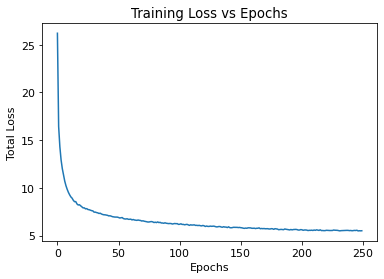

In [7]:
# Plot training total loss wrt. epochs
plt.plot(total_losses)
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Training Loss vs Epochs")

## Inference

In [5]:
def detect_faces(image, conf_thres=0.4, img_size=640):
    org_shape = image.shape
    img = letterbox(image, new_shape=img_size)[0]

    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to CxHXW
    img = np.ascontiguousarray(img)
    img = img.astype(np.float64)
    
    img = torch.from_numpy(img).to(device).float()

    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    t1 = time_synchronized()
    pred = model(img)[0]

    pred = non_max_suppression(pred,conf_thres, 0.35,
                               multi_label=False, classes=0, agnostic= False,land=True ,point_num=point_num)

    t2 = time_synchronized()
    # Postprocess detections
    dets = []
    for i, det in enumerate(pred):  # detections per image
        if det is not None:
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], org_shape).round()
                det[:, 5:5+point_num*2] = scale_coords(img.shape[2:], det[:, 5:5+point_num*2], org_shape).round()
                dets.append(det.detach().cpu().numpy())

    return np.array(dets)

Choose an image folder, a net type and a weight file for inference.

In [6]:
image_folder = "../data/inputs/images/"
net_type = "mbv2_1"
weights = f"../weights/{net_type}_best.pt"

In [7]:
device = '0' if torch.cuda.is_available() else 'cpu'
          
device = select_device(device)
model = get_model(net_type, device, weights, inference=True)
print(model.info())

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1660 Ti', total_memory=6144MB)

[32, 96, 160]
Model Summary: 210 layers, 1.54421e+06 parameters, 1.54421e+06 gradients
None


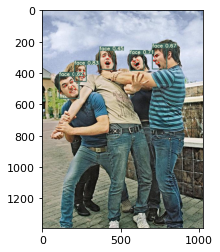

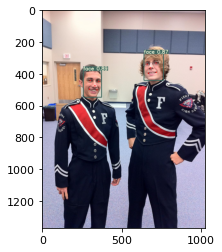

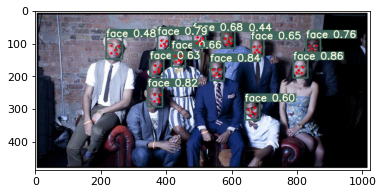

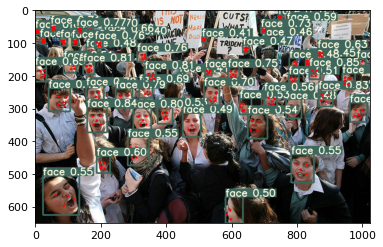

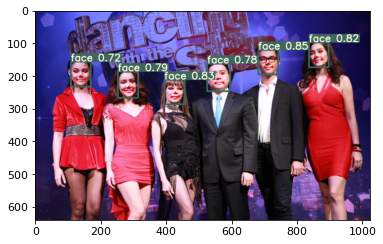

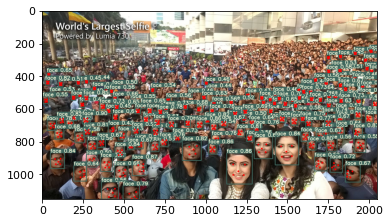

In [15]:
point_num = hyp['point_num']
names = ["face", "no_face"]
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
image_exts = ['jpg', 'png', 'jpeg']

file_paths = sorted(glob.glob(os.path.join(image_folder, '*.*'))) 
image_paths = [x for x in file_paths if x.split('.')[-1].lower() in image_exts]

for image_path in image_paths:
    image = cv2.imread(image_path)
    predictions = detect_faces(image, conf_thres=0.4, img_size=640)
    try:
        predictions = predictions[0]
    except:
        continue
    
    # Show results on images
    for (*bbox, conf), (*landmarks,cls) in zip(reversed(predictions[:, :5]), reversed(predictions[:, 5:])):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(bbox, image, label=label, color=colors[int(cls)], line_thickness=3)
        plot_one_landmarks(landmarks, image)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image)

## Tests

In [8]:
# Build bbox_overlaps
%cd ./evaluations/widerface
!python setup.py install
%cd ../..
%pwd

D:\Users\Sefaburak\Desktop\Courses\Cogs\MSc-1st(2020-2021)\Fall\Mmi727\project\project_files\yolov3-facial-landmark-detection\src\evaluations\widerface
running install
running build
running build_ext
building 'box_overlaps' extension
creating build\temp.win-amd64-3.7
creating build\temp.win-amd64-3.7\Release
D:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.24.28314\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -IC:\Users\Sefaburak\MiniConda3\lib\site-packages\numpy\core\include -IC:\Users\Sefaburak\MiniConda3\include -IC:\Users\Sefaburak\MiniConda3\include "-ID:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.24.28314\include" "-ID:\Windows Kits\10\include\10.0.18362.0\ucrt" "-ID:\Windows Kits\10\include\10.0.18362.0\shared" "-ID:\Windows Kits\10\include\10.0.18362.0\um" "-ID:\Windows Kits\10\include\10.0.18362.0\winrt" "-ID:\Windows Kits\10\include\10.0.18362.0\cppwinrt" /Tcbox_overlaps.c /Fobuild\temp.win-amd64-

'D:\\Users\\Sefaburak\\Desktop\\Courses\\Cogs\\MSc-1st(2020-2021)\\Fall\\Mmi727\\project\\project_files\\yolov3-facial-landmark-detection\\src'

### 1. Evaluation of Face Detection on Widerface Validation Dataset

In [9]:
from test import save_widerface_predictions
from evaluations import evaluate_widerface

In [10]:
val_image_root = "/home/sefa/data/widerface/val/images/"
val_results_root = f"../outputs/widerface_results/{net_type}/"

save_widerface_predictions(model, val_image_root, val_results_root)

In [11]:
pred_path = "../outputs/widerface_results/mbv2_1/"
gt_path = "./evaluations/widerface/ground_truth/"

evaluate_widerface(pred_path, gt_path)

Processing easy: 100%|█████████████████████████████████████████████████████████████████| 61/61 [00:17<00:00,  3.52it/s]
D:\Users\Sefaburak\Desktop\Courses\Cogs\MSc-1st(2020-2021)\Fall\Mmi727\project\project_files\yolov3-facial-landmark-detection\src\evaluations\widerface\evaluate_widerface.py:204: RuntimeWarning: invalid value encountered in double_scalars
  _pr_curve[i, 0] = pr_curve[i, 1] / pr_curve[i, 0]
Processing hard: 100%|█████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.12it/s]

==================== Results ====================
Easy   Val AP: 0.861193909637135
Medium Val AP: 0.849145017309316
Hard   Val AP: 0.6649306161041503


### 2. Evaluation of Facial Landmarks Extraction on Widerface Validation Dataset

In [ ]:
from test import save_wflw_predictions
from evaluations import evaluate_wflw

In [ ]:
val_labels_path = "/home/sefa/Downloads/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"
val_image_root = "/home/sefa/Downloads/WFLW_images/"
val_results_root = f"../outputs/wlfw_results/{net_type}/"


save_wflw_predictions(model, val_labels_path, val_image_root, val_results_root)

In [ ]:
pred_path = "../outputs/widerface_results/mbv2_1/"
gt_path = "./evaluations/widerface/ground_truth/"

evaluate_widerface(pred_path, gt_path)